# **🌾 Prédiction du Rendement du Riz : Objectif et Pertinence**

---


L’objectif est de modéliser et prédire le rendement en riz (kg/parcelle) à partir des pratiques agricoles et des conditions environnementales observées.

Cette approche est pertinente car :

- Le rendement varie de façon extrême — de 5 000 à plus de 40 000 kg par parcelle, ce qui reflète des stratégies de gestion très contrastées.

- Le dataset fournit un riche ensemble de variables explicatives : engrais (DAP, Urée, Potasse), pesticide, paille recyclée, surface, variété, températures, pluie, etc.

- Un modèle prédictif fiable permettrait non seulement d’anticiper la production, mais aussi de quantifier l’impact réel de chaque décision agricole sur le rendement — transformant ainsi les données en levier d’optimisation concrète.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configuration des graphiques
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

sns.set_palette("husl")

In [3]:
# Charger le fichier original
df = pd.read_csv('data/paddy_dataset_fe.csv', sep=',', encoding='utf-8', low_memory=False)
# Création d'une copie pour ne pas modifier df original
df_reg = df.copy()

In [4]:
# Aperçu des premières lignes
print("APERÇU DES DONNÉES:")
print("-" * 30)
print(df_reg.head())
print()

APERÇU DES DONNÉES:
------------------------------
   Hectares   Seedrate(in Kg)  LP_Mainfield(in Tonnes)  Nursery area (Cents)  \
0        6.0            150.0                     75.0                 120.0   
1        6.0            150.0                     75.0                 120.0   
2        6.0            150.0                     75.0                 120.0   
3        6.0            150.0                     75.0                 120.0   
4        4.0            150.0                     75.0                 120.0   

   LP_nurseryarea(in Tonnes)  DAP_20days  Weed28D_thiobencarb  Urea_40Days  \
0                        6.0       240.0                 12.0       162.78   
1                        6.0       240.0                 12.0       162.78   
2                        6.0       240.0                 12.0       162.78   
3                        6.0       240.0                 12.0       162.78   
4                        6.0       240.0                 12.0       162.78   


**MODÉLISATION**

In [5]:
# Dictionnaire pour stocker les résultats
results = {}

def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    """
    Entraîne et évalue un modèle
    """
    # Entraînement
    model.fit(X_train, y_train)

    # Prédictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Métriques sur l'ensemble d'entraînement
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    # Métriques sur l'ensemble de test
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Validation croisée
    cv_scores = cross_val_score(model, X_train, y_train, cv=5,
                                scoring='neg_root_mean_squared_error')
    cv_rmse = -cv_scores.mean()

    return {
        'Model': name,
        'Train_RMSE': train_rmse,
        'Train_MAE': train_mae,
        'Train_R2': train_r2,
        'Test_RMSE': test_rmse,
        'Test_MAE': test_mae,
        'Test_R2': test_r2,
        'CV_RMSE': cv_rmse,
        'Predictions_Train': y_train_pred,
        'Predictions_Test': y_test_pred
    }

**1. SelectKBest**

In [6]:
# Target
target = 'Paddy yield(in Kg)'
y = df[target]
X = df_reg.drop(target, axis=1)

print(f"Nombre total de features avant sélection : {X.shape[1]}")

# ========================================
# 1. Feature Selection avec SelectKBest (univarié)
# ========================================

# On garde les 12 meilleures features selon f_regression
selector = SelectKBest(score_func=f_regression, k=12)
X_selected = selector.fit_transform(X, y)

# Récupérer les noms des features sélectionnées
selected_features = X.columns[selector.get_support()].tolist()

print(f"Features sélectionnées ({len(selected_features)}) :")
print(selected_features)

# Nouveau DataFrame avec seulement les features sélectionnées + cible
df_selected = df_reg[selected_features + [target]]

# ========================================
# 2. Train-Test Split
# ========================================
X_train, X_test, y_train, y_test = train_test_split(
    df_selected.drop(target, axis=1),
    df_selected[target],
    test_size=0.2,
    random_state=42
)

# ========================================
# 3. Scaling
# ========================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTrain set : {X_train.shape}")
print(f"Test set  : {X_test.shape}")
print("Données prêtes pour la modélisation !")

Nombre total de features avant sélection : 84
Features sélectionnées (12) :
['Hectares ', 'Seedrate(in Kg)', 'LP_Mainfield(in Tonnes)', 'Nursery area (Cents)', 'LP_nurseryarea(in Tonnes)', 'DAP_20days', 'Weed28D_thiobencarb', 'Urea_40Days', 'Potassh_50Days', 'Micronutrients_70Days', 'Pest_60Day(in ml)', 'Trash(in bundles)']

Train set : (2231, 12)
Test set  : (558, 12)
Données prêtes pour la modélisation !


**1.1. LINEAR REGRESSION**

In [7]:
# ----------------------------------------------------------------
# 1. LINEAR REGRESSION
# ----------------------------------------------------------------

print("\n1. LINEAR REGRESSION")
print("-" * 35)

lr_model = LinearRegression()
results['Linear Regression'] = evaluate_model('Linear Regression', lr_model,
                                              X_train_scaled, X_test_scaled, y_train, y_test)

print(f"  Train RMSE: {results['Linear Regression']['Train_RMSE']:.4f}")
print(f"  Test RMSE:  {results['Linear Regression']['Test_RMSE']:.4f}")
print(f"  Train MAE:  {results['Linear Regression']['Train_MAE']:.4f}")
print(f"  Test MAE:   {results['Linear Regression']['Test_MAE']:.4f}")
print(f"  Train R²:   {results['Linear Regression']['Train_R2']:.4f}")
print(f"  Test R²:    {results['Linear Regression']['Test_R2']:.4f}")
print(f"  CV RMSE:    {results['Linear Regression']['CV_RMSE']:.4f}")


1. LINEAR REGRESSION
-----------------------------------
  Train RMSE: 2662.5794
  Test RMSE:  3025.5347
  Train MAE:  1540.0833
  Test MAE:   1692.1765
  Train R²:   0.9114
  Test R²:    0.8759
  CV RMSE:    2692.0481


**1.2. LASSO REGRESSION**

In [8]:
# ----------------------------------------------------------------
# 2. LASSO REGRESSION
# ----------------------------------------------------------------

print("\n2. LASSO REGRESSION")
print("-" * 35)

lasso_model = Lasso(alpha=0.001, max_iter=10000, random_state=42)
results['Lasso'] = evaluate_model('Lasso', lasso_model,
                                 X_train_scaled, X_test_scaled, y_train, y_test)

print(f"  Train RMSE: {results['Lasso']['Train_RMSE']:.4f}")
print(f"  Test RMSE:  {results['Lasso']['Test_RMSE']:.4f}")
print(f"  Train MAE:  {results['Lasso']['Train_MAE']:.4f}")
print(f"  Test MAE:   {results['Lasso']['Test_MAE']:.4f}")
print(f"  Train R²:   {results['Lasso']['Train_R2']:.4f}")
print(f"  Test R²:    {results['Lasso']['Test_R2']:.4f}")
print(f"  CV RMSE:    {results['Lasso']['CV_RMSE']:.4f}")

# Nombre de coefficients non-nuls
non_zero_coef = np.sum(lasso_model.coef_ != 0)
print(f"  Coefficients non-nuls: {non_zero_coef}/{len(lasso_model.coef_)}")


2. LASSO REGRESSION
-----------------------------------
  Train RMSE: 2662.5794
  Test RMSE:  3025.5355
  Train MAE:  1540.0832
  Test MAE:   1692.1770
  Train R²:   0.9114
  Test R²:    0.8759
  CV RMSE:    2692.0481
  Coefficients non-nuls: 12/12


**1.3. RIDGE REGRESSION**

In [9]:
# ----------------------------------------------------------------
# 3. RIDGE REGRESSION
# ----------------------------------------------------------------

print("\n3. RIDGE REGRESSION")
print("-" * 35)

ridge_model = Ridge(alpha=10, random_state=42)
results['Ridge'] = evaluate_model('Ridge', ridge_model,
                                 X_train_scaled, X_test_scaled, y_train, y_test)

print(f"  Train RMSE: {results['Ridge']['Train_RMSE']:.4f}")
print(f"  Test RMSE:  {results['Ridge']['Test_RMSE']:.4f}")
print(f"  Train MAE:  {results['Ridge']['Train_MAE']:.4f}")
print(f"  Test MAE:   {results['Ridge']['Test_MAE']:.4f}")
print(f"  Train R²:   {results['Ridge']['Train_R2']:.4f}")
print(f"  Test R²:    {results['Ridge']['Test_R2']:.4f}")
print(f"  CV RMSE:    {results['Ridge']['CV_RMSE']:.4f}")


3. RIDGE REGRESSION
-----------------------------------
  Train RMSE: 2662.6026
  Test RMSE:  3024.7118
  Train MAE:  1541.6480
  Test MAE:   1693.1153
  Train R²:   0.9114
  Test R²:    0.8760
  CV RMSE:    2689.7781


**1.4. ELASTIC NET**

In [10]:
# ----------------------------------------------------------------
# 4. ELASTIC NET
# ----------------------------------------------------------------

print("\n4. ELASTIC NET")
print("-" * 35)

elasticnet_model = ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10000,
                             random_state=42)
results['ElasticNet'] = evaluate_model('ElasticNet', elasticnet_model,
                                      X_train_scaled, X_test_scaled, y_train, y_test)

print(f"  Train RMSE: {results['ElasticNet']['Train_RMSE']:.4f}")
print(f"  Test RMSE:  {results['ElasticNet']['Test_RMSE']:.4f}")
print(f"  Train MAE:  {results['ElasticNet']['Train_MAE']:.4f}")
print(f"  Test MAE:   {results['ElasticNet']['Test_MAE']:.4f}")
print(f"  Train R²:   {results['ElasticNet']['Train_R2']:.4f}")
print(f"  Test R²:    {results['ElasticNet']['Test_R2']:.4f}")
print(f"  CV RMSE:    {results['ElasticNet']['CV_RMSE']:.4f}")

non_zero_coef_en = np.sum(elasticnet_model.coef_ != 0)
print(f"  Coefficients non-nuls: {non_zero_coef_en}/{len(elasticnet_model.coef_)}")


4. ELASTIC NET
-----------------------------------
  Train RMSE: 2662.5798
  Test RMSE:  3025.4379
  Train MAE:  1540.2579
  Test MAE:   1692.2771
  Train R²:   0.9114
  Test R²:    0.8759
  CV RMSE:    2691.8272
  Coefficients non-nuls: 12/12


**1.5. XGBOOST REGRESSOR**

In [11]:
# ----------------------------------------------------------------
# 5. XGBOOST REGRESSOR
# ----------------------------------------------------------------

import xgboost as xgb

print("\n5. XGBOOST REGRESSOR")
print("-" * 35)

# Initialisation du modèle
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Entraînement et évaluation
results['XGBoost'] = evaluate_model('XGBoost', xgb_model,
                                    X_train_scaled, X_test_scaled, y_train, y_test)

# Affichage des résultats
print(f"  Train RMSE: {results['XGBoost']['Train_RMSE']:.4f}")
print(f"  Test RMSE:  {results['XGBoost']['Test_RMSE']:.4f}")
print(f"  Train MAE:  {results['XGBoost']['Train_MAE']:.4f}")
print(f"  Test MAE:   {results['XGBoost']['Test_MAE']:.4f}")
print(f"  Train R²:   {results['XGBoost']['Train_R2']:.4f}")
print(f"  Test R²:    {results['XGBoost']['Test_R2']:.4f}")
print(f"  CV RMSE:    {results['XGBoost']['CV_RMSE']:.4f}")


5. XGBOOST REGRESSOR
-----------------------------------
  Train RMSE: 2162.6091
  Test RMSE:  2938.8180
  Train MAE:  1160.2737
  Test MAE:   1550.2892
  Train R²:   0.9415
  Test R²:    0.8830
  CV RMSE:    2854.9650


**1.6 COMPARAISON DES MODÈLES**


----------------------------------------------------------------------
COMPARAISON DES MODÈLES
----------------------------------------------------------------------

TABLEAU COMPARATIF:
           Modèle  Train_RMSE   Test_RMSE   Train_MAE    Test_MAE  Train_R2  Test_R2     CV_RMSE
Linear Regression 2662.579445 3025.534733 1540.083317 1692.176523  0.911354 0.875941 2692.048066
            Lasso 2662.579445 3025.535485 1540.083202 1692.176965  0.911354 0.875941 2692.048099
            Ridge 2662.602648 3024.711781 1541.648028 1693.115343  0.911352 0.876008 2689.778112
       ElasticNet 2662.579758 3025.437852 1540.257909 1692.277097  0.911354 0.875949 2691.827249
          XGBoost 2162.609102 2938.818048 1160.273671 1550.289234  0.941519 0.882950 2854.965031


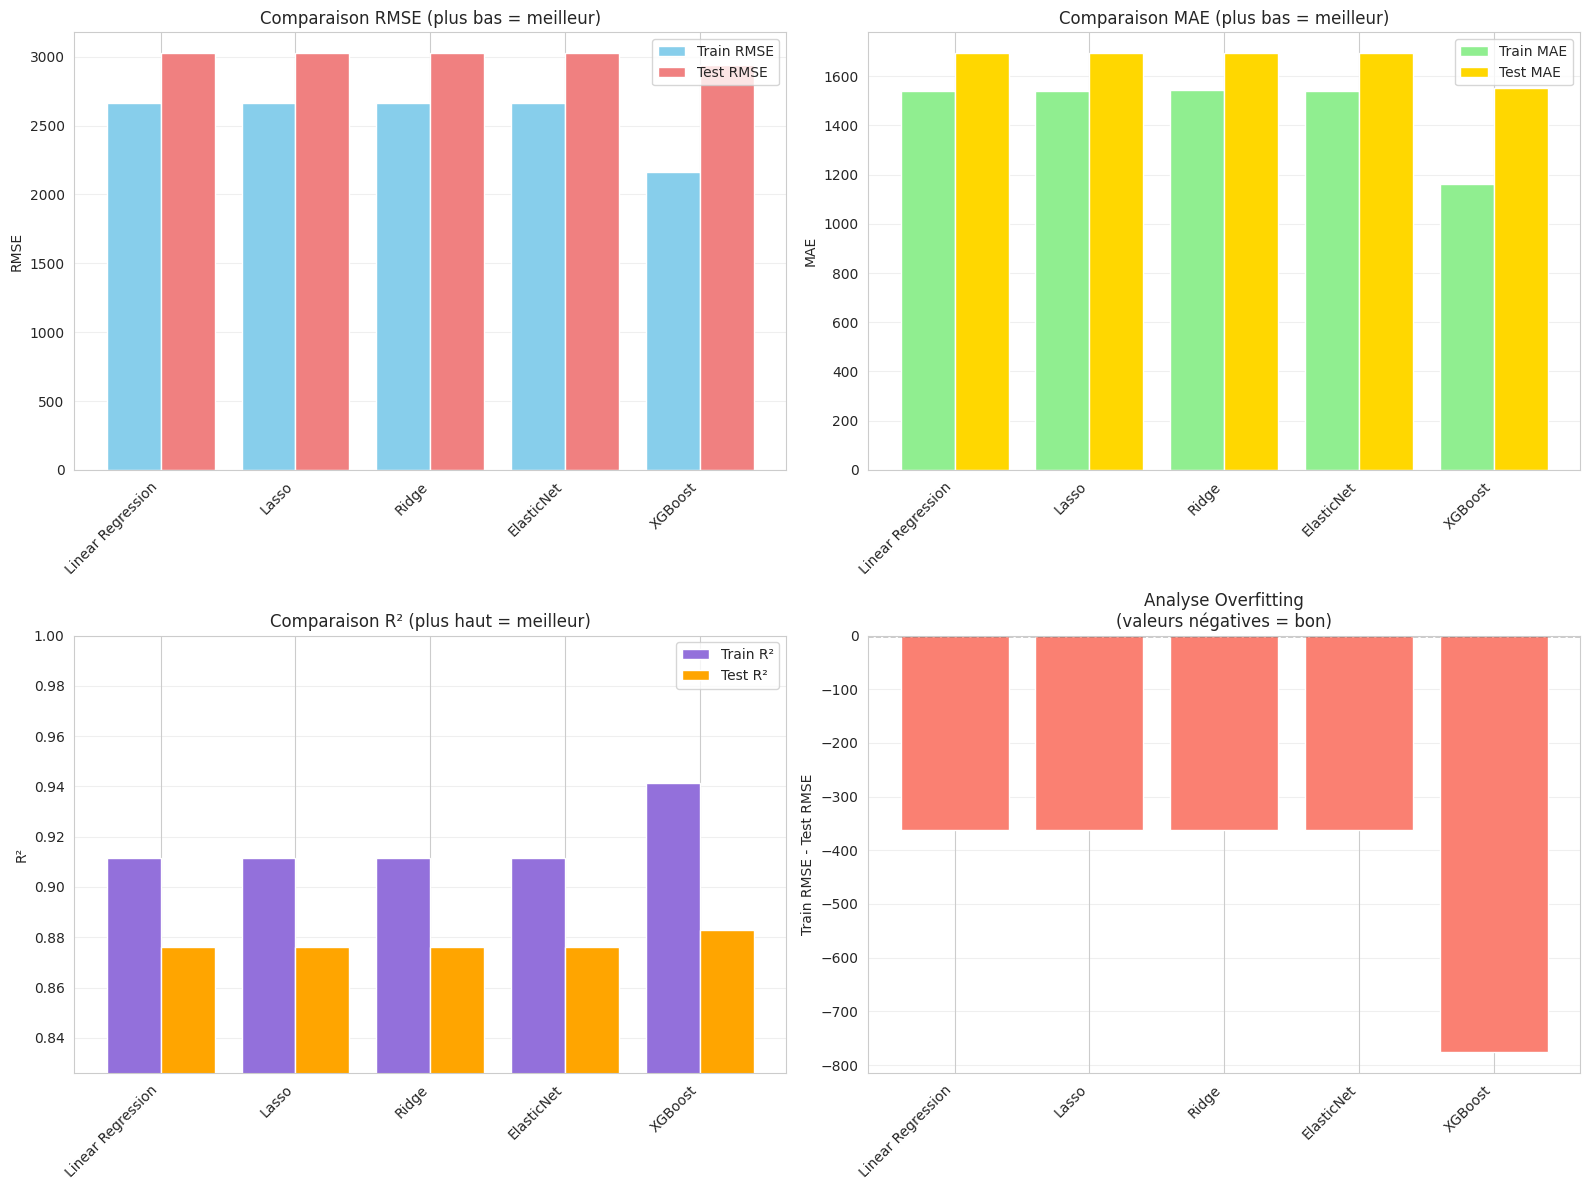

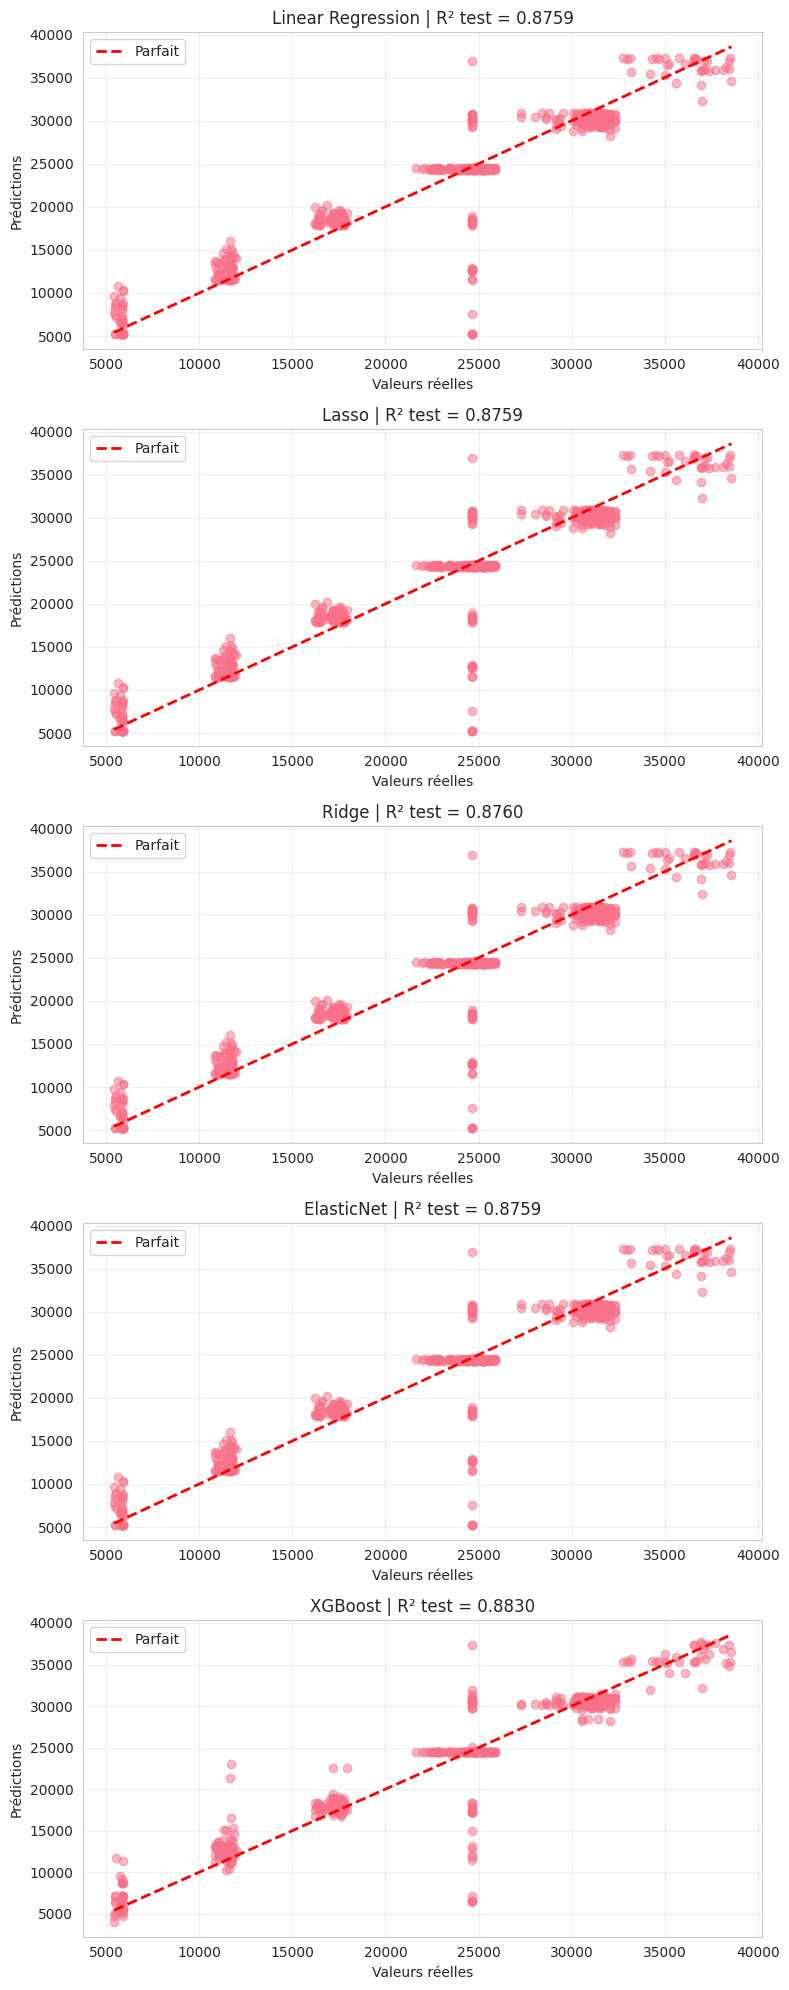

In [12]:
# ----------------------------------------------------------------
# COMPARAISON DES MODÈLES
# ----------------------------------------------------------------

print("\n" + "-"*70)
print("COMPARAISON DES MODÈLES")
print("-"*70)

comparison_df = pd.DataFrame({
    'Modèle': list(results.keys()),
    'Train_RMSE': [results[m]['Train_RMSE'] for m in results.keys()],
    'Test_RMSE': [results[m]['Test_RMSE'] for m in results.keys()],
    'Train_MAE': [results[m]['Train_MAE'] for m in results.keys()],
    'Test_MAE': [results[m]['Test_MAE'] for m in results.keys()],
    'Train_R2': [results[m]['Train_R2'] for m in results.keys()],
    'Test_R2': [results[m]['Test_R2'] for m in results.keys()],
    'CV_RMSE': [results[m]['CV_RMSE'] for m in results.keys()]
})

print("\nTABLEAU COMPARATIF:")
print(comparison_df.to_string(index=False))

# Visualisation de la comparaison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

models = list(results.keys())
x_pos = np.arange(len(models))

# RMSE Comparison
axes[0, 0].bar(x_pos - 0.2, comparison_df['Train_RMSE'], 0.4,
              label='Train RMSE', color='skyblue')
axes[0, 0].bar(x_pos + 0.2, comparison_df['Test_RMSE'], 0.4,
              label='Test RMSE', color='lightcoral')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(models, rotation=45, ha='right')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].set_title('Comparaison RMSE (plus bas = meilleur)')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# MAE Comparison
axes[0, 1].bar(x_pos - 0.2, comparison_df['Train_MAE'], 0.4,
              label='Train MAE', color='lightgreen')
axes[0, 1].bar(x_pos + 0.2, comparison_df['Test_MAE'], 0.4,
              label='Test MAE', color='gold')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(models, rotation=45, ha='right')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].set_title('Comparaison MAE (plus bas = meilleur)')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# R² Comparison
axes[1, 0].bar(x_pos - 0.2, comparison_df['Train_R2'], 0.4,
              label='Train R²', color='mediumpurple')
axes[1, 0].bar(x_pos + 0.2, comparison_df['Test_R2'], 0.4,
              label='Test R²', color='orange')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(models, rotation=45, ha='right')
axes[1, 0].set_ylabel('R²')
axes[1, 0].set_title('Comparaison R² (plus haut = meilleur)')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].set_ylim([min(comparison_df['Test_R2'])-0.05, 1.0])

# Overfitting analysis (différence Train-Test)
overfit_rmse = comparison_df['Train_RMSE'] - comparison_df['Test_RMSE']
axes[1, 1].bar(x_pos, overfit_rmse, color='salmon')
axes[1, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(models, rotation=45, ha='right')
axes[1, 1].set_ylabel('Train RMSE - Test RMSE')
axes[1, 1].set_title('Analyse Overfitting\n(valeurs négatives = bon)')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Prédictions vs Valeurs réelles
n_models = len(models)

fig, axes = plt.subplots(
    n_models, 1, figsize=(8, 4 * n_models)
)

# Cas où il n’y a qu’un seul modèle
if n_models == 1:
    axes = [axes]

for i, model_name in enumerate(models):
    y_pred = results[model_name]['Predictions_Test']

    axes[i].scatter(y_test, y_pred, alpha=0.5)
    axes[i].plot(
        [y_test.min(), y_test.max()],
        [y_test.min(), y_test.max()],
        'r--', lw=2, label='Parfait'
    )
    axes[i].set_xlabel('Valeurs réelles')
    axes[i].set_ylabel('Prédictions')
    axes[i].set_title(
        f'{model_name} | R² test = {results[model_name]["Test_R2"]:.4f}'
    )
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


`Ridge semble être le modèle le plus robuste et le plus fiable.`



**2. BACKWARD ELIMINATION**

In [13]:
# ================================================================
# BACKWARD ELIMINATION
# ================================================================

print("\n\n" + "="*70)
print("PARTIE III: SÉLECTION DE VARIABLES PAR BACKWARD ELIMINATION")
print("="*70)

print("\n" + "-"*70)
print("BACKWARD ELIMINATION")
print("-"*70)

def backward_elimination(X, y, significance_level=0.05):
    """
    Effectue une élimination backward basée sur les p-values

    Paramètres:
    -----------
    X : DataFrame
        Features
    y : Series
        Target
    significance_level : float
        Seuil de significativité (défaut: 0.05)

    Retourne:
    ---------
    selected_features : list
        Liste des features sélectionnées
    """
    features = list(X.columns)
    removed_features = []

    print(f"\nDébut: {len(features)} variables")
    print(f"Seuil de significativité: {significance_level}")

    iteration = 0
    while True:
        iteration += 1

        # Ajouter une constante
        X_with_const = sm.add_constant(X[features])

        # Ajuster le modèle
        model = sm.OLS(y, X_with_const).fit()

        # Trouver la variable avec la p-value la plus élevée
        p_values = model.pvalues.iloc[1:]  # Exclure la constante
        max_p_value = p_values.max()

        if max_p_value > significance_level:
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
            removed_features.append((excluded_feature, max_p_value))

            if iteration <= 10 or iteration % 10 == 0:
                print(f"Itération {iteration}: Retrait de '{excluded_feature}' (p-value={max_p_value:.4f})")
        else:
            break

    print(f"\nTerminé après {iteration} itérations")
    print(f"Variables conservées: {len(features)}")
    print(f"Variables retirées: {len(removed_features)}")

    return features, removed_features

# Appliquer backward elimination
selected_features, removed_features = backward_elimination(X_train, y_train,
                                                          significance_level=0.05)

print(f"\n{len(selected_features)} variables sélectionnées sur {X_train.shape[1]}")
print(f"Réduction: {(1 - len(selected_features)/X_train.shape[1])*100:.1f}%")

# Afficher quelques variables retirées
print("\nPremières variables retirées (Top 10 p-values):")
removed_sorted = sorted(removed_features, key=lambda x: x[1], reverse=True)
for feat, pval in removed_sorted[:10]:
    print(f"  • {feat}: p-value = {pval:.6f}")

# Préparer les nouveaux ensembles train/test avec les variables sélectionnées
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print(f"\nNouvelles dimensions:")
print(f"  X_train: {X_train_selected.shape}")



PARTIE III: SÉLECTION DE VARIABLES PAR BACKWARD ELIMINATION

----------------------------------------------------------------------
BACKWARD ELIMINATION
----------------------------------------------------------------------

Début: 12 variables
Seuil de significativité: 0.05

Terminé après 1 itérations
Variables conservées: 12
Variables retirées: 0

12 variables sélectionnées sur 12
Réduction: 0.0%

Premières variables retirées (Top 10 p-values):

Nouvelles dimensions:
  X_train: (2231, 12)


In [14]:
# ===========================
# BACKWARD ELIMINATION
# ===========================
selected_features, removed_features = backward_elimination(X_train, y_train,
                                                          significance_level=0.05)

print(f"\n{len(selected_features)} variables sélectionnées sur {X_train.shape[1]}")
print(f"Réduction: {(1 - len(selected_features)/X_train.shape[1])*100:.1f}%")

# Afficher les 10 premières variables retirées
removed_sorted = sorted(removed_features, key=lambda x: x[1], reverse=True)
print("\nPremières variables retirées (Top 10 p-values):")
for feat, pval in removed_sorted[:10]:
    print(f"  • {feat}: p-value = {pval:.6f}")

# ===========================
# Préparer les ensembles train/test sélectionnés
# ===========================
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print(f"\nNouvelles dimensions après sélection:")
print(f"  X_train: {X_train_selected.shape}")
print(f"  X_test : {X_test_selected.shape}")

# ===========================
# Appliquer le scaling seulement sur les features sélectionnées
# ===========================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

print("\nDonnées prêtes pour la modélisation avec features sélectionnées !")


Début: 12 variables
Seuil de significativité: 0.05

Terminé après 1 itérations
Variables conservées: 12
Variables retirées: 0

12 variables sélectionnées sur 12
Réduction: 0.0%

Premières variables retirées (Top 10 p-values):

Nouvelles dimensions après sélection:
  X_train: (2231, 12)
  X_test : (558, 12)

Données prêtes pour la modélisation avec features sélectionnées !


*Principe de fonctionnement*

---




**Backward Elimination**
```
1. Entraîner un modèle avec toutes les variables

2. Identifier la variable la moins significative

3. La supprimer

4. Réentraîner le modèle

5. Répéter jusqu’à un critère d’arrêt

```
**SelectKBest**
```
1. Calculer un score pour chaque variable

2. Trier les variables par score

3. Sélectionner les K meilleures

4. Pas de ré-entraînement du modèle pendant la sélection
```



**2.1 LINEAR REGRESSION**

In [15]:
# ----------------------------------------------------------------
# 1. LINEAR REGRESSION
# ----------------------------------------------------------------

print("\n1. LINEAR REGRESSION")
print("-" * 35)

lr_model = LinearRegression()
results['Linear Regression'] = evaluate_model('Linear Regression', lr_model,
                                              X_train_scaled, X_test_scaled, y_train, y_test)

print(f"  Train RMSE: {results['Linear Regression']['Train_RMSE']:.4f}")
print(f"  Test RMSE:  {results['Linear Regression']['Test_RMSE']:.4f}")
print(f"  Train MAE:  {results['Linear Regression']['Train_MAE']:.4f}")
print(f"  Test MAE:   {results['Linear Regression']['Test_MAE']:.4f}")
print(f"  Train R²:   {results['Linear Regression']['Train_R2']:.4f}")
print(f"  Test R²:    {results['Linear Regression']['Test_R2']:.4f}")


1. LINEAR REGRESSION
-----------------------------------
  Train RMSE: 2662.5794
  Test RMSE:  3025.5347
  Train MAE:  1540.0833
  Test MAE:   1692.1765
  Train R²:   0.9114
  Test R²:    0.8759


**2.2 LASSO REGRESSION**

In [16]:
# ----------------------------------------------------------------
# 2. LASSO REGRESSION
# ----------------------------------------------------------------

print("\n2. LASSO REGRESSION")
print("-" * 35)

lasso_model = Lasso(alpha=0.001, max_iter=10000, random_state=42)
results['Lasso'] = evaluate_model('Lasso', lasso_model,
                                 X_train_scaled, X_test_scaled, y_train, y_test)

print(f"  Train RMSE: {results['Lasso']['Train_RMSE']:.4f}")
print(f"  Test RMSE:  {results['Lasso']['Test_RMSE']:.4f}")
print(f"  Train MAE:  {results['Lasso']['Train_MAE']:.4f}")
print(f"  Test MAE:   {results['Lasso']['Test_MAE']:.4f}")
print(f"  Train R²:   {results['Lasso']['Train_R2']:.4f}")
print(f"  Test R²:    {results['Lasso']['Test_R2']:.4f}")
print(f"  CV RMSE:    {results['Lasso']['CV_RMSE']:.4f}")

# Nombre de coefficients non-nuls
non_zero_coef = np.sum(lasso_model.coef_ != 0)
print(f"  Coefficients non-nuls: {non_zero_coef}/{len(lasso_model.coef_)}")


2. LASSO REGRESSION
-----------------------------------
  Train RMSE: 2662.5794
  Test RMSE:  3025.5355
  Train MAE:  1540.0832
  Test MAE:   1692.1770
  Train R²:   0.9114
  Test R²:    0.8759
  CV RMSE:    2692.0481
  Coefficients non-nuls: 12/12


**2.3. RIDGE REGRESSION**

In [17]:
# ----------------------------------------------------------------
# 3. RIDGE REGRESSION
# ----------------------------------------------------------------

print("\n3. RIDGE REGRESSION")
print("-" * 35)

ridge_model = Ridge(alpha=10, random_state=42)
results['Ridge'] = evaluate_model('Ridge', ridge_model,
                                 X_train_scaled, X_test_scaled, y_train, y_test)

print(f"  Train RMSE: {results['Ridge']['Train_RMSE']:.4f}")
print(f"  Test RMSE:  {results['Ridge']['Test_RMSE']:.4f}")
print(f"  Train MAE:  {results['Ridge']['Train_MAE']:.4f}")
print(f"  Test MAE:   {results['Ridge']['Test_MAE']:.4f}")
print(f"  Train R²:   {results['Ridge']['Train_R2']:.4f}")
print(f"  Test R²:    {results['Ridge']['Test_R2']:.4f}")
print(f"  CV RMSE:    {results['Ridge']['CV_RMSE']:.4f}")


3. RIDGE REGRESSION
-----------------------------------
  Train RMSE: 2662.6026
  Test RMSE:  3024.7118
  Train MAE:  1541.6480
  Test MAE:   1693.1153
  Train R²:   0.9114
  Test R²:    0.8760
  CV RMSE:    2689.7781


**2.4. ELASTIC NET**

In [18]:
# ----------------------------------------------------------------
# 4. ELASTIC NET
# ----------------------------------------------------------------

print("\n4. ELASTIC NET")
print("-" * 35)

elasticnet_model = ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10000,
                             random_state=42)
results['ElasticNet'] = evaluate_model('ElasticNet', elasticnet_model,
                                      X_train_scaled, X_test_scaled, y_train, y_test)

print(f"  Train RMSE: {results['ElasticNet']['Train_RMSE']:.4f}")
print(f"  Test RMSE:  {results['ElasticNet']['Test_RMSE']:.4f}")
print(f"  Train MAE:  {results['ElasticNet']['Train_MAE']:.4f}")
print(f"  Test MAE:   {results['ElasticNet']['Test_MAE']:.4f}")
print(f"  Train R²:   {results['ElasticNet']['Train_R2']:.4f}")
print(f"  Test R²:    {results['ElasticNet']['Test_R2']:.4f}")
print(f"  CV RMSE:    {results['ElasticNet']['CV_RMSE']:.4f}")

non_zero_coef_en = np.sum(elasticnet_model.coef_ != 0)
print(f"  Coefficients non-nuls: {non_zero_coef_en}/{len(elasticnet_model.coef_)}")


4. ELASTIC NET
-----------------------------------
  Train RMSE: 2662.5798
  Test RMSE:  3025.4379
  Train MAE:  1540.2579
  Test MAE:   1692.2771
  Train R²:   0.9114
  Test R²:    0.8759
  CV RMSE:    2691.8272
  Coefficients non-nuls: 12/12


**2.5. XGBOOST REGRESSOR**

In [19]:
# ----------------------------------------------------------------
# 5. XGBOOST REGRESSOR
# ----------------------------------------------------------------

import xgboost as xgb

print("\n5. XGBOOST REGRESSOR")
print("-" * 35)

# Initialisation du modèle
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Entraînement et évaluation
results['XGBoost'] = evaluate_model('XGBoost', xgb_model,
                                    X_train_scaled, X_test_scaled, y_train, y_test)

# Affichage des résultats
print(f"  Train RMSE: {results['XGBoost']['Train_RMSE']:.4f}")
print(f"  Test RMSE:  {results['XGBoost']['Test_RMSE']:.4f}")
print(f"  Train MAE:  {results['XGBoost']['Train_MAE']:.4f}")
print(f"  Test MAE:   {results['XGBoost']['Test_MAE']:.4f}")
print(f"  Train R²:   {results['XGBoost']['Train_R2']:.4f}")
print(f"  Test R²:    {results['XGBoost']['Test_R2']:.4f}")
print(f"  CV RMSE:    {results['XGBoost']['CV_RMSE']:.4f}")


5. XGBOOST REGRESSOR
-----------------------------------
  Train RMSE: 2162.6091
  Test RMSE:  2938.8180
  Train MAE:  1160.2737
  Test MAE:   1550.2892
  Train R²:   0.9415
  Test R²:    0.8830
  CV RMSE:    2854.9650


**2.6 COMPARAISON DES MODÈLES**


----------------------------------------------------------------------
COMPARAISON DES MODÈLES
----------------------------------------------------------------------

TABLEAU COMPARATIF:
           Modèle  Train_RMSE   Test_RMSE   Train_MAE    Test_MAE  Train_R2  Test_R2     CV_RMSE
Linear Regression 2662.579445 3025.534733 1540.083317 1692.176523  0.911354 0.875941 2692.048066
            Lasso 2662.579445 3025.535485 1540.083202 1692.176965  0.911354 0.875941 2692.048099
            Ridge 2662.602648 3024.711781 1541.648028 1693.115343  0.911352 0.876008 2689.778112
       ElasticNet 2662.579758 3025.437852 1540.257909 1692.277097  0.911354 0.875949 2691.827249
          XGBoost 2162.609102 2938.818048 1160.273671 1550.289234  0.941519 0.882950 2854.965031


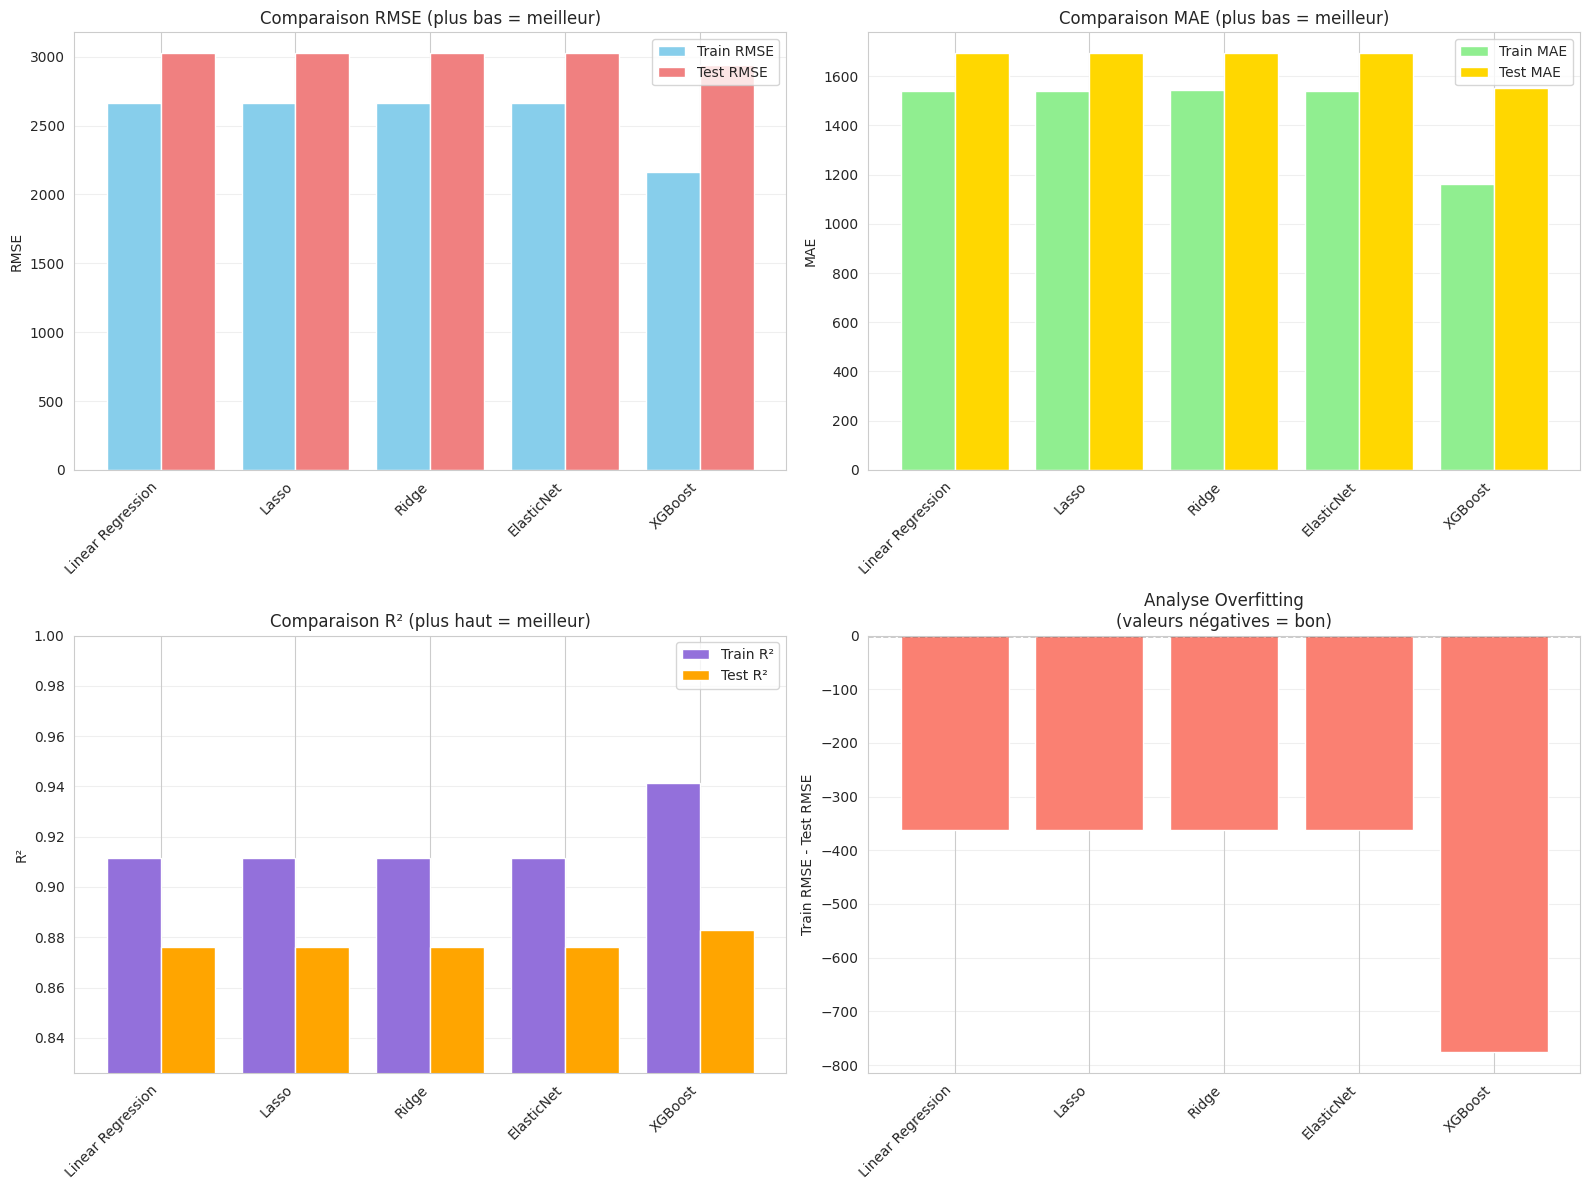

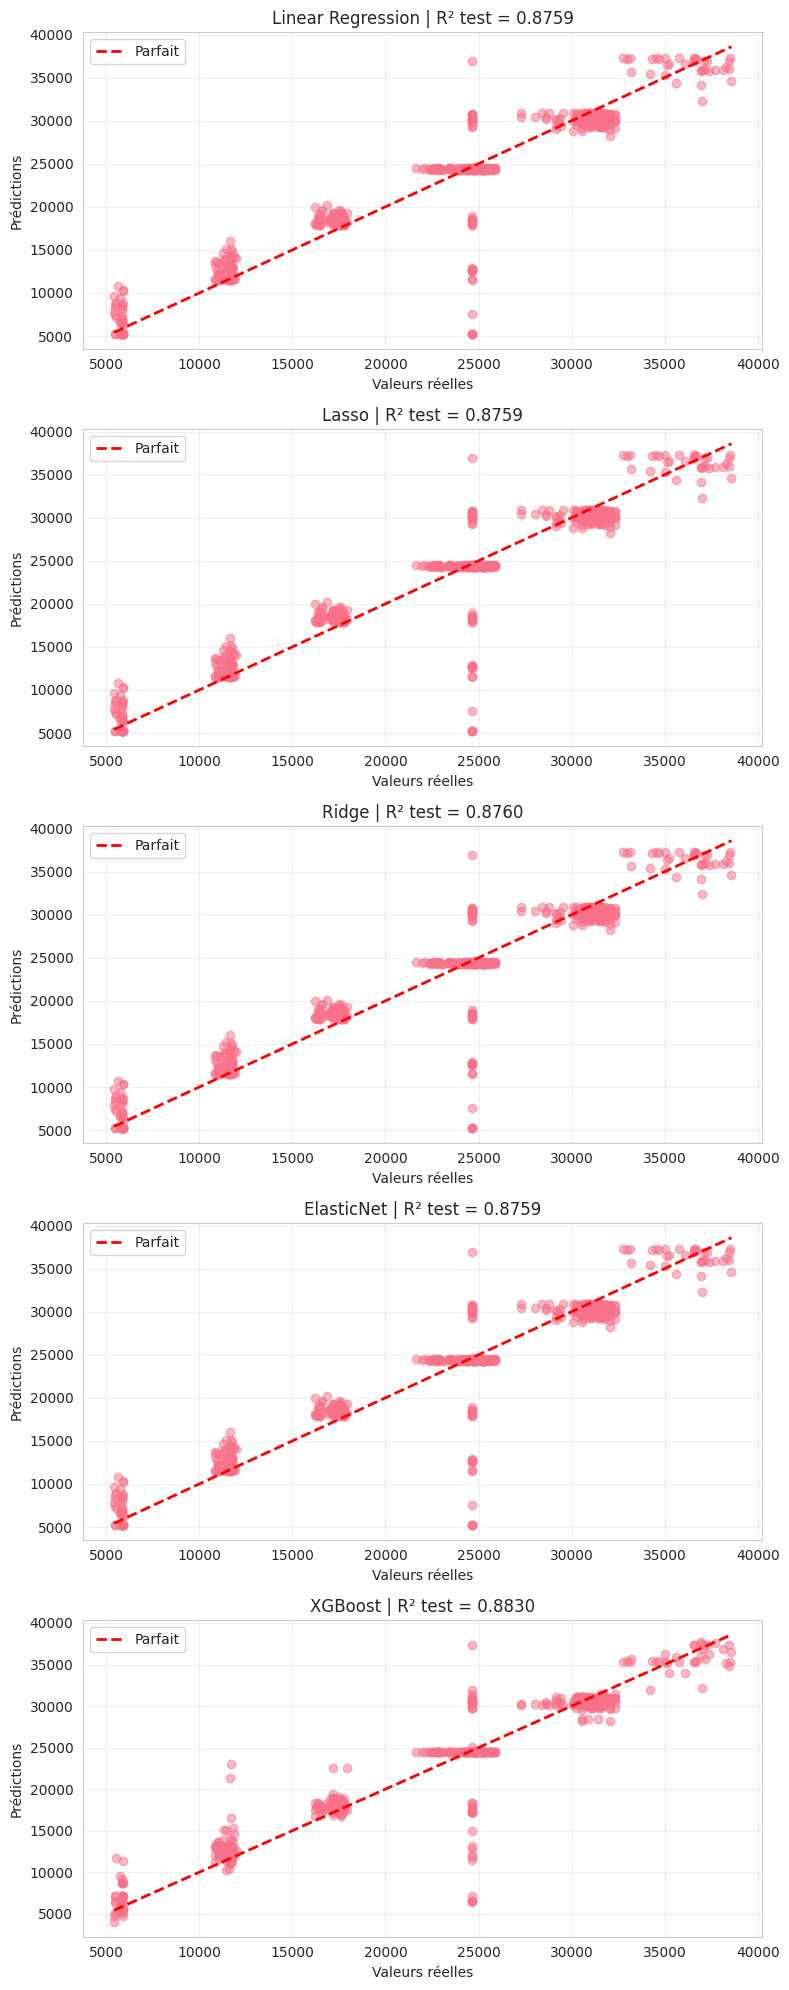

In [20]:
# ----------------------------------------------------------------
# COMPARAISON DES MODÈLES
# ----------------------------------------------------------------

print("\n" + "-"*70)
print("COMPARAISON DES MODÈLES")
print("-"*70)

comparison_df = pd.DataFrame({
    'Modèle': list(results.keys()),
    'Train_RMSE': [results[m]['Train_RMSE'] for m in results.keys()],
    'Test_RMSE': [results[m]['Test_RMSE'] for m in results.keys()],
    'Train_MAE': [results[m]['Train_MAE'] for m in results.keys()],
    'Test_MAE': [results[m]['Test_MAE'] for m in results.keys()],
    'Train_R2': [results[m]['Train_R2'] for m in results.keys()],
    'Test_R2': [results[m]['Test_R2'] for m in results.keys()],
    'CV_RMSE': [results[m]['CV_RMSE'] for m in results.keys()],
})

print("\nTABLEAU COMPARATIF:")
print(comparison_df.to_string(index=False))

# Visualisation de la comparaison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

models = list(results.keys())
x_pos = np.arange(len(models))

# RMSE Comparison
axes[0, 0].bar(x_pos - 0.2, comparison_df['Train_RMSE'], 0.4,
              label='Train RMSE', color='skyblue')
axes[0, 0].bar(x_pos + 0.2, comparison_df['Test_RMSE'], 0.4,
              label='Test RMSE', color='lightcoral')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(models, rotation=45, ha='right')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].set_title('Comparaison RMSE (plus bas = meilleur)')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# MAE Comparison
axes[0, 1].bar(x_pos - 0.2, comparison_df['Train_MAE'], 0.4,
              label='Train MAE', color='lightgreen')
axes[0, 1].bar(x_pos + 0.2, comparison_df['Test_MAE'], 0.4,
              label='Test MAE', color='gold')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(models, rotation=45, ha='right')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].set_title('Comparaison MAE (plus bas = meilleur)')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# R² Comparison
axes[1, 0].bar(x_pos - 0.2, comparison_df['Train_R2'], 0.4,
              label='Train R²', color='mediumpurple')
axes[1, 0].bar(x_pos + 0.2, comparison_df['Test_R2'], 0.4,
              label='Test R²', color='orange')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(models, rotation=45, ha='right')
axes[1, 0].set_ylabel('R²')
axes[1, 0].set_title('Comparaison R² (plus haut = meilleur)')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].set_ylim([min(comparison_df['Test_R2'])-0.05, 1.0])

# Overfitting analysis (différence Train-Test)
overfit_rmse = comparison_df['Train_RMSE'] - comparison_df['Test_RMSE']
axes[1, 1].bar(x_pos, overfit_rmse, color='salmon')
axes[1, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(models, rotation=45, ha='right')
axes[1, 1].set_ylabel('Train RMSE - Test RMSE')
axes[1, 1].set_title('Analyse Overfitting\n(valeurs négatives = bon)')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Prédictions vs Valeurs réelles
n_models = len(models)

fig, axes = plt.subplots(
    n_models, 1, figsize=(8, 4 * n_models)
)

# Cas où il n’y a qu’un seul modèle
if n_models == 1:
    axes = [axes]

for i, model_name in enumerate(models):
    y_pred = results[model_name]['Predictions_Test']

    axes[i].scatter(y_test, y_pred, alpha=0.5)
    axes[i].plot(
        [y_test.min(), y_test.max()],
        [y_test.min(), y_test.max()],
        'r--', lw=2, label='Parfait'
    )
    axes[i].set_xlabel('Valeurs réelles')
    axes[i].set_ylabel('Prédictions')
    axes[i].set_title(
        f'{model_name} | R² test = {results[model_name]["Test_R2"]:.4f}'
    )
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

- Test RMSE (erreur quadratique) :	XGBoost → 2938.82 (plus bas)
- Test MAE (erreur absolue)	: XGBoost → 1550.29 (plus bas)
- Test R² (variance expliquée) :	XGBoost → 0.88295 (plus haut)

`Bien que la régression linéaire, Lasso, Ridge et ElasticNet aient des performances correctes (R² ~0.875–0.876), XGBoost surpasse tous les modèles sur toutes les métriques test.`


- SelectKBest → pour filtrer rapidement un petit nombre de features importantes.

- Backward Elimination → pour une sélection précise et interprétable, mais plus lente.

- GridSearchCV → pour optimiser le modèle final après avoir choisi les features.

**3. GridSearchCV**

In [21]:
# ------------------------------------------------------------
# 1. Définir les modèles optimisés (après GridSearchCV)
# ------------------------------------------------------------
optimized_models = {
    "Ridge Optimisé": Ridge(alpha=10, random_state=42),
    "Lasso Optimisé": Lasso(alpha=0.0001, max_iter=10000, random_state=42),
    "ElasticNet Optimisé": ElasticNet(alpha=0.1, l1_ratio=0.9, max_iter=10000, random_state=42),
    "XGBoost Optimisé": XGBRegressor(
        n_estimators=500,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
}

# ------------------------------------------------------------
# 2. Fonction pour entraîner et évaluer un modèle
# ------------------------------------------------------------
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # CV RMSE (XGBoost peut lancer un warning avec cross_val_score si eval_metric)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    cv_rmse = -cv_scores.mean()

    return {
        'Model': name,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_MAE': train_mae,
        'Test_MAE': test_mae,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'CV_RMSE': cv_rmse
    }

# ------------------------------------------------------------
# 3. Évaluer tous les modèles optimisés
# ------------------------------------------------------------
results_optimized = {}
for name, model in optimized_models.items():
    results_optimized[name] = evaluate_model(name, model, X_train_selected, X_test_selected, y_train, y_test)

# ------------------------------------------------------------
# 4. Créer le tableau comparatif final
# ------------------------------------------------------------
comparison_df_optimized = pd.DataFrame({
    'Modèle': [results_optimized[m]['Model'] for m in results_optimized],
    'Train_RMSE': [results_optimized[m]['Train_RMSE'] for m in results_optimized],
    'Test_RMSE': [results_optimized[m]['Test_RMSE'] for m in results_optimized],
    'Train_MAE': [results_optimized[m]['Train_MAE'] for m in results_optimized],
    'Test_MAE': [results_optimized[m]['Test_MAE'] for m in results_optimized],
    'Train_R2': [results_optimized[m]['Train_R2'] for m in results_optimized],
    'Test_R2': [results_optimized[m]['Test_R2'] for m in results_optimized],
    'CV_RMSE': [results_optimized[m]['CV_RMSE'] for m in results_optimized],
})

print("\nTABLEAU COMPARATIF DES MODÈLES OPTIMISÉS:")
print(comparison_df_optimized.to_string(index=False))


TABLEAU COMPARATIF DES MODÈLES OPTIMISÉS:
             Modèle  Train_RMSE   Test_RMSE   Train_MAE    Test_MAE  Train_R2  Test_R2     CV_RMSE
     Ridge Optimisé 2662.599343 3024.809722 1540.437463 1692.248916  0.911352 0.876000 2691.741725
     Lasso Optimisé 2662.579445 3025.534708 1540.083331 1692.176523  0.911354 0.875941 2692.048064
ElasticNet Optimisé 2662.675028 3023.985477 1540.864015 1692.331844  0.911347 0.876068 2691.562800
   XGBoost Optimisé 2162.609102 2938.818048 1160.273671 1550.289234  0.941519 0.882950 2854.965031




```
1. XGBoost Optimisé est le meilleur modèle globalement :

- Plus faible RMSE et MAE

- Meilleur R² (train et test)

- Captures non-linéarités et interactions que les modèles linéaires n’expliquent pas

2. Les modèles linéaires (Ridge, Lasso, ElasticNet) sont proches entre eux et se comportent très bien pour des relations linéaires, mais ils sont légèrement moins performants que XGBoost sur ce dataset.
```

In [22]:
# Créer le dossier si nécessaire
os.makedirs("regression", exist_ok=True)

# Sauvegarde du modèle
joblib.dump(xgb_model, "regression/xgboost_paddy_model.pkl")

# Chargement ultérieur
loaded_model = joblib.load("regression/xgboost_paddy_model.pkl")

In [23]:
# Faire des prédictions
y_pred = loaded_model.predict(X_test_scaled)
print("Prédictions générées avec le modèle chargé :", y_pred[:5])

# Calcul des métriques
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Performance du modèle chargé sur le jeu de test :")
print(f"RMSE : {rmse:.2f}")
print(f"MAE  : {mae:.2f}")
print(f"R²   : {r2:.3f}")

Prédictions générées avec le modèle chargé : [24517.86  24517.86  24517.86  28223.752 17162.39 ]
Performance du modèle chargé sur le jeu de test :
RMSE : 2938.82
MAE  : 1550.29
R²   : 0.883


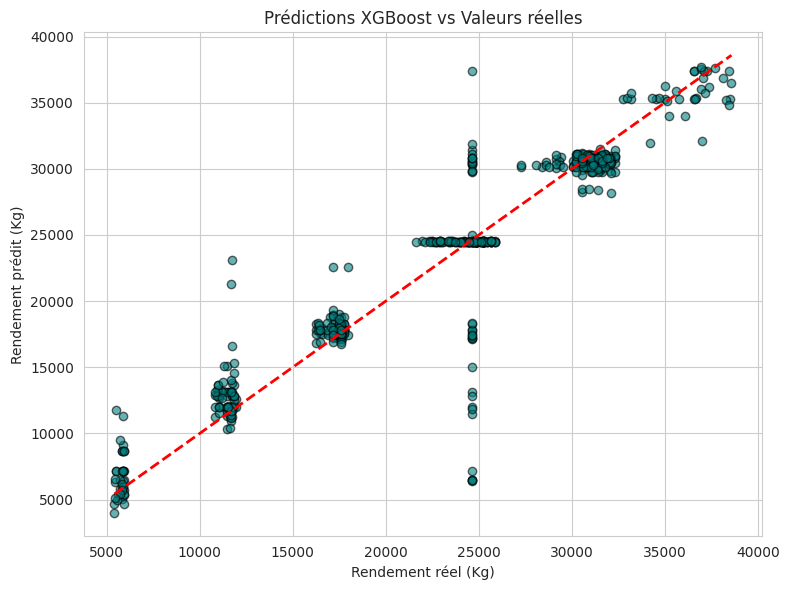

In [24]:
# Valeurs réelles et prédictions
y_true = y_test.values
y_pred_values = y_pred  # depuis le modèle chargé

plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred_values, alpha=0.6, color='teal', edgecolor='k')
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         'r--', linewidth=2)  # ligne y = x

plt.xlabel("Rendement réel (Kg)")
plt.ylabel("Rendement prédit (Kg)")
plt.title("Prédictions XGBoost vs Valeurs réelles")
plt.grid(True)
plt.tight_layout()
plt.show()


```
Les points proches de la ligne rouge y = x montrent de bonnes prédictions.
Les points qui s’éloignent indiquent des erreurs plus importantes.
```